In [1]:
from sbhandler import *
from pickle import load, dump

In [2]:
# load_matlab_file function Testing
file_name = 'consensus1.mat'
variable_of_interest = 'align3'
h5py_object, data = load_matlab_file(file_name, variable_name=variable_of_interest)

# DNA_seqs can be used to grab each raw_seqblock
DNA_seqs = DNA_SeqBlocks(h5py_object=h5py_object, data=data) 

FILE_SIZE = DNA_seqs.size #Constant

In [3]:
# Load in barcodes and truelens for the day
import pickle
df = pickle.load(open('pickle/v2BarcodesTruelen.pickle', 'rb'))
BARCODES = df.barcode
TRUELENS = df.true_len

In [4]:
# Make sure it works on a small dataset first.
tinyDS = range(1, 10001)
DS = range(1, FILE_SIZE+1)

## GET BFP-parsed seqblocks

In [ ]:
# bfp_list = []
# rfp_list = []

# for i in DS:
#     end = TRUELENS[i]
#     b, r = DNA_seqs.get_br(i, end)
#     bfp_list.append(b)
#     rfp_list.append(r)

In [76]:
# import pickle
# with open('raw_bfp.pickle', 'wb') as f:
#     pickle.dump(bfp_list, f)

# import pickle
# with open('raw_rfp.pickle', 'wb') as f:
#     pickle.dump(rfp_list, f)

In [5]:
# Load 'em in 
import pickle
bfp_list = pickle.load( open('raw_bfp.pickle', 'rb'))
rfp_list = pickle.load( open('raw_rfp.pickle', 'rb'))

### Calculating Adjusted Real Error vs. Q score and nucleotide

In [73]:
# -----
# For each qscore (except 32): track value[0] observed, value[1] incorrect
each_qscore = {'correct' : 0, 'A' : 0, 'C' : 0, 'G' : 0, 'T' : 0, '-' : 0}

# tracking = {'A' : { i : each_qscore for i in np.arange(32,127) },
            # 'C' : { i : each_qscore for i in np.arange(32,127) },
            # 'T' : { i : each_qscore for i in np.arange(32,127) },
            # 'G' : { i : each_qscore for i in np.arange(32,127) },
            # '-' : { i : each_qscore for i in np.arange(32,127) }}
tracking = {'A' : { i : [0,0,0,0,0,0] for i in np.arange(32,127)},
            'C' : {i : [0,0,0,0,0,0] for i in np.arange(32,127)},
            'G' : {i : [0,0,0,0,0,0] for i in np.arange(32,127)},
            'T' : {i : [0,0,0,0,0,0] for i in np.arange(32,127)},
            '-' : {i : [0,0,0,0,0,0] for i in np.arange(32,127)}}

def hot_encode(num):
    if num == 65: return 1
    if num ==67: return 2
    if num ==71: return 3
    if num == 84: return 4
    else: return 5
for bfp in bfp_list:
    cov = int((len(bfp.columns)-4)/2) # New rename() will include it in the first two chars
    for read_num in range(1, cov+1):
        read = bfp[f'read{read_num}']
        for nuc in range(len(read.index)):
            true_nuc = bfp.iloc[nuc,0]
            chr_tnuc = chr(true_nuc) # convert to a chr the targ
            qscore = bfp[f'q{read_num}'].iloc[nuc] # The qscore
            check = read.iloc[nuc] # 
            if check == true_nuc: # If correct. Add to observed
                # tracking[chr_tnuc][qscore] = tracking[chr_tnuc].setdefault(qscore, {'correct' : 0,65:0,67:0,71:0,84:0,45:0})
                # tracking[chr_tnuc][qscore]['correct'] += 1
                tracking[chr_tnuc][qscore][0] += 1
            else: # If they disagree
                # tracking[chr_tnuc][qscore] = tracking[chr_tnuc].setdefault(qscore, {'correct':0, 65:0,67:0,71:0,84:0,45:0})
                # tracking[chr_tnuc][qscore][chr(check)] += 1
                tracking[chr_tnuc][qscore][hot_encode(check)] +=1


        

In [124]:
# Save tracking for now

# with open( 'trackingv1.pickle', 'wb') as f:
#     pickle.dump(tracking, f)

In [6]:
# Import tracking
tracking = pickle.load(open('trackingv1.pickle', 'rb'))

Look at just 

In [167]:
# Let's start basic
# Just 'A' and total wrong
# Remember that 33 is useless. 32 does not exist.
to_plot = {'A' : [], 'C' : [], 'G' : [], 'T' : []}


raw_x = [i for i in np.arange(35, 127)] #34 is 0 in test

for n in ['A', 'C', 'G', 'T']:
    raw_y = []
    focus = tracking[n]
    for i in focus.keys():
        if i < 35: continue
        stats = focus.get(i)
        total = sum(stats)
        wrong = sum(stats[1:])
        if total == 0:
            raw_y.append(0)
        else: raw_y.append(wrong/total)
    to_plot[n] = raw_y




In [168]:
%matplotlib inline
import math
import matplotlib.pyplot as plt

for nuc in ['A', 'C', 'G', 'T']:
    to_change = to_plot[nuc]
    for i in range(len(to_change)):
        if to_change[i] == 0: 
            to_change[i] = 0 
        else: 
            to_change[i] = math.log(to_change[i])


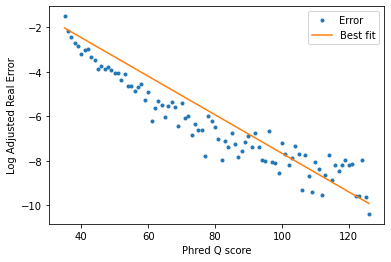

In [155]:
fig, axes = plt.subplots(2,2, sharex=True, sharey=True)
for i in range(2):
    for j in range(2):
        for nuc in ['A', 'C', 'G', 'T']:
            axes[i,j].scatter(to_plot[nuc]


#### Optional: Use torch to calculate the line of best fit of the data (Machine Learning)

In [121]:
# Desired func y = mx + b => # params are m, b
import torch
p = torch.randn(2).requires_grad_()

In [ ]:
x = torch.tensor(x).long()
y=torch.tensor(y).float()

class Dataset(torch.utils.data.Dataset):
    def __init__(self, x,y):
        super().__init__()
        self.x,self.y = x,y
        self.len = len(x)
    def __len__(self): return self.len
    def __getitem__(self, idx): return x[idx], y[idx]

testds = torch.utils.data.DataLoader(Dataset(x,y), batch_size=3)

In [ ]:
def func(params, input):
    a, b = params
    return a*input + b

import torch.functional as F
from fastai.vision.all import *
from fastbook import *

def loss_func(pred, targ):
    # Let's use RMSE
    return ((pred-targ)**2).sqrt()

lr = 1e-5
for i in range(100):
    loss_total = 0
    n_obs = 0
    for xin, yin in testds:
        
        pred = func(p, xin)
        loss = loss_func(pred, yin).mean()
        
        loss.backward() 
        p.data -= p.grad.data * lr
        p.grad = None
        
        n = len(xin)
        loss_total += loss.item()*n
        n_obs +=n
        
    print(loss_total/n_obs)

In [127]:
def f(x):
    a,b =p.data
    return a*x+b

In [135]:
y=[]
for i in raw_x:
    y.append(f(i))
    